Companion notebook for the paper "Critical Role of local Monte Carlo steps in machine-learning-driven Sequential Tempering"

Python version: 3.6.9 

Packages used:

- torch: 1.10.2
- numpy: 1.19.5
- matplotlib: 3.3.4

# Imports and definitions

In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

In [2]:
# transition matrix for the Markov chain
def get_transition_matrix_absm(N, beta):
    """
    Get the transition matrix for the system in magnetization space.

    Parameters:
    - N (int): The number of spins in the system.
    - beta (float): The inverse temperature (1/kT) of the system.

    Returns:
    - torch.Tensor: A transition matrix of shape ((N/2)+1, (N/2)+1) representing 
                  the probabilities of transitioning between different magnetization states.
    """
    P = torch.zeros((int(N/2)+1, int(N/2)+1))

    for i in range(0, int(N/2)+1):
        m = i*2/N
        if i == 0:
            P[i, 1] = 1
        else: 
            P[i, i-1] = (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N))
            P[i, i] = 1 - (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N)) - (1-np.abs(m))/2
            if i != N/2:
                P[i, i+1] = (1-np.abs(m))/2
    return P

#Thomas method for solving the system of equations in the form of (A7)

def thomas_solve(A):
    """
    Solves Ax = d where A is a tridiagonal matrix and d is a vector of ones.

    Arguments:
    - A: Tridiagonal matrix (torch tensor of shape (n, n))

    Returns:
    - x: Solution vector
    """
    n = A.shape[0]  # Number of equations

    # Extract the diagonals
    a = torch.zeros(n, dtype=torch.float32)
    b = torch.zeros(n, dtype=torch.float32)
    c = torch.zeros(n, dtype=torch.float32)

    for i in range(n):
        b[i] = A[i, i]  # Main diagonal
        if i > 0:
            a[i] = A[i, i - 1]  # Sub-diagonal
        if i < n - 1:
            c[i] = A[i, i + 1]  # Super-diagonal

    # Right-hand side vector d (all ones)
    d = torch.ones(n, dtype=torch.float32)

    # Temporary storage for modified coefficients
    c_prime = torch.zeros(n, dtype=torch.float32)
    d_prime = torch.zeros(n, dtype=torch.float32)

    # Forward sweep
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]

    for i in range(1, n):
        denom = b[i] - a[i] * c_prime[i - 1]
        c_prime[i] = c[i] / denom if i < n - 1 else 0  # c[n-1] is unused
        d_prime[i] = (d[i] - a[i] * d_prime[i - 1]) / denom

    # Back substitution
    x = torch.zeros(n, dtype=torch.float32)
    x[-1] = d_prime[-1]

    for i in range(n - 2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i + 1]
    

    return x

# gaussian distribution. Since we are interested in the discretized version, we multiply the pdf by Delta m = 2/N
def gaussian_m(m, N):
    """compute the gaussian distribution for a given magnetization m and number of spins N"""
    return np.sqrt(2/N/np.pi)*np.exp(-N*m**2/2)

def large_dev_m(m, N):
    """compute the large deviation function for a given magnetization m and number of spins N"""
    x = (1+m)/2
    return np.exp(-N*(x * np.log(2*x) + (1 - x) * np.log(2*(1 - x))))

In [3]:
import numpy as np

def binomial_prob(N, m):
    """
    Compute the binomial coefficient for int((1 + m) / 2 * N) successes out of N trials.

    Parameters:
    - N (int): Total number of trials.
    - m (float): A parameter in the range [-1, 1].

    Returns:
    - int: The binomial coefficient.
    """
    k = int((1 + m) / 2 * N)  # Compute the number of successes
    
    # Compute the binomial coefficient using factorials
    numerator = np.math.factorial(N)
    denominator = np.math.factorial(k) * np.math.factorial(N - k)
    
    return numerator // denominator/2**N  # Integer division for exact result


In [4]:
def get_transition_matrix_made(N, beta):
    """
    Get the transition matrix for the system in magnetization space.

    Parameters:
    - N (int): The number of spins in the system.
    - beta (float): The inverse temperature (1/kT) of the system.

    Returns:
    - torch.Tensor: A transition matrix of shape ((N/2)+1, (N/2)+1) representing 
                  the probabilities of transitioning between different magnetization states.
    """
    P = torch.zeros((int(N/2)+1, int(N/2)+1))

    probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
    probMADE_abs = probMADE.copy()
    probMADE_abs[0] = gaussian_m(0, N)
    for i in range(0, int(N/2)+1):
        for j in range(0, int(N/2)+1):
            m1 = i*2/N
            m2 = j*2/N
            P[i, j] += probMADE[j]*min(1, np.exp(beta*N/2*(m2*m2-m1*m1))*probMADE[i]/probMADE[j])
            P[i,i] += probMADE[j]*(1-min(1, np.exp(beta*N/2*(m2*m2-m1*m1))*probMADE[i]/probMADE[j]))
            print(m1, m2, np.exp(beta*N/2*(m2*m2-m1*m1)), probMADE[i]/probMADE[j], min(1, np.exp(beta*N/2*(m2*m2-m1*m1))*probMADE[i]/probMADE[j]))
    return P

# Computations

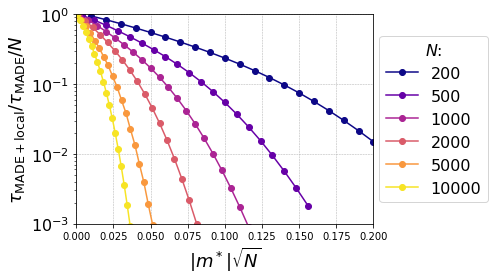

In [6]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()
        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)
all_data_og = list(all_data)
# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i],d[:, 1]/ d[:, 2], marker='o', label=f"{Nvalues[i]}", color=color)

plt.axvline(x=np.sqrt(3), color='k', linestyle='--')
plt.yscale("log")
plt.ylim(10**(-3), 1.)
plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|\sqrt{N}$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}/N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

In [7]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
Nvalues = [200,500, 1000] # values of N to consider

m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)
    transition_made = get_transition_matrix_made(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()
        # first passage time for MADE
        P = transition_made[:nmax, :nmax]
        fpt_made = N*torch.inverse(torch.eye(P.size(0)) - P)[0].sum()
        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i],d[:, 1]/ d[:, 2], marker='o', label=f"{Nvalues[i]}", color=color)

#plt.axvline(x=np.sqrt(3), color='k', linestyle='--')
plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|\sqrt{N}$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}/N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

0.0 0.0 1.0 1.0 1
0.0 0.01 1.0120722888660778 1.010050167084168 1
0.0 0.02 1.0491706553244706 1.0408107741923882 1
0.0 0.03 1.1140477453864677 1.0941742837052104 1
0.0 0.04 1.2116705169649005 1.1735108709918103 1
0.0 0.05 1.3498588075760032 1.2840254166877414 1
0.0 0.06 1.540335115161127 1.4333294145603404 1
0.0 0.07 1.8003840441397765 1.6323162199553791 1
0.0 0.08 2.155451037931604 1.8964808793049515 1
0.0 0.09 2.643225627680798 2.2479079866764713 1
0.0 0.1 3.320116922736548 2.718281828459046 1
0.0 0.11 4.271649276115181 3.3534846525490236 1
0.0 0.12 5.629383874402168 4.220695816996553 1
0.0 0.13 7.598873404088091 5.419480705131207 1
0.0 0.14 10.506561849304235 7.099327065156634 1
0.0 0.15 14.87973172487283 9.487735836358526 1
0.0 0.16 21.585029592894678 12.935817315543078 1
0.0 0.17 32.07253319052099 17.993309601550322 1
0.0 0.18 48.81316250727554 25.533721747351517 1
0.0 0.19 76.09632713220853 36.9660528148225 1
0.0 0.2 121.51041751873497 54.598150033144286 1
0.0 0.21 198.7405092116

KeyboardInterrupt: 

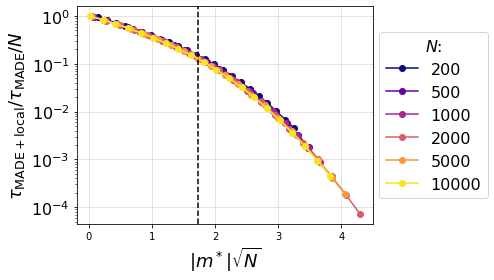

In [14]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()
        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**0.5,d[:, 1]/ d[:, 2], marker='o', label=f"{Nvalues[i]}", color=color)

plt.axvline(x=np.sqrt(3), color='k', linestyle='--')
plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|\sqrt{N}$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}/N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

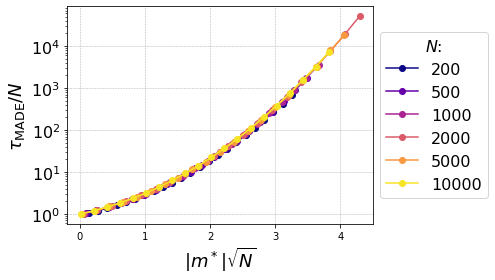

In [106]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()
        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**0.5, d[:, 2]/ Nvalues[i], marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|\sqrt{N}$', fontsize=18)
plt.ylabel(r'$ \tau_{\mathrm{MADE}}/N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

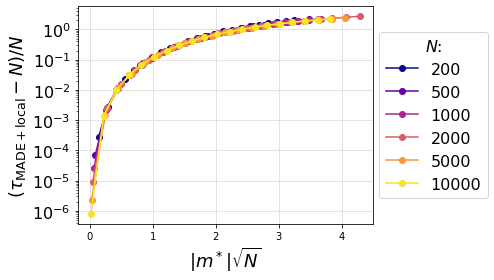

In [119]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()
        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**0.5,(d[:, 1]-Nvalues[i])/Nvalues[i], marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|\sqrt{N}$', fontsize=18)
plt.ylabel(r'$(\tau_{\mathrm{MADE+local}} -N)/N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

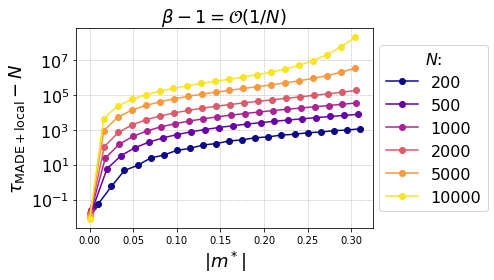

In [122]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):
    N = Nvalues[i]
    beta = 1+1/N
    m_max = 0.32
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**1, (d[:, 1]-Nvalues[i]), marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} -N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
plt.title(r'$\beta-1 = \mathcal{O}(1/N)$ ', fontsize=18)
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()


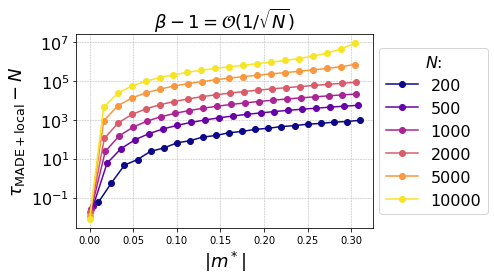

In [12]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):
    N = Nvalues[i]
    beta = 1+1/np.sqrt(N)
    m_max = 0.32
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**1, (d[:, 1]-Nvalues[i]), marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} -N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
plt.title(r'$\beta-1 = \mathcal{O}(1/\sqrt{N})$ ', fontsize=18)
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()


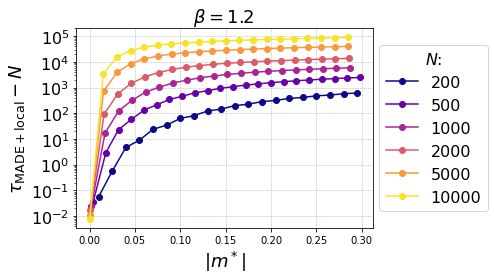

In [123]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = 0.3
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**1, (d[:, 1]-Nvalues[i]), marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} -N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
plt.title(r'$\beta=1.2$ ', fontsize=18)
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()


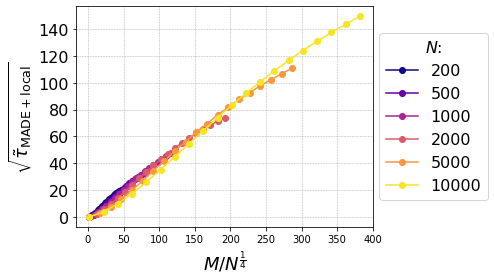

In [125]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = (0*N+thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)
all_data_withmade = list(all_data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
        plt.plot(d[:, 0], (d[:, 1])**0.5, marker='o', label=f"{Nvalues[i]}", color=color)


#plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 200)
plt.xlabel(r'$M/N^\frac{1}{4}$', fontsize=18)
plt.ylabel(r'$\sqrt{\tilde{\tau}_{\mathrm{MADE+local}}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

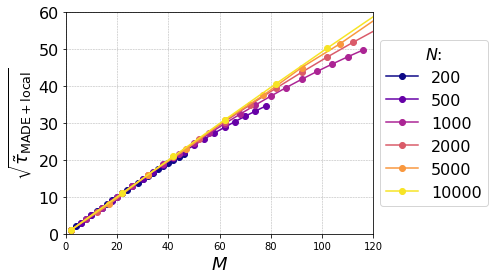

In [131]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = (thomas_solve(torch.eye(P.size(0))-P))[0]

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)
all_data_nomade = list(all_data)


# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0], (d[:, 1])**0.5, marker='o', label=f"{Nvalues[i]}", color=color)

#plt.xscale("log")
#plt.yscale("log")

#plt.ylim(10**(-3), 1.)
plt.xlim(0, 120)
plt.ylim(0, 60)

plt.xlabel(r'$M$', fontsize=18)
plt.ylabel(r'$\sqrt{\tilde{\tau}_{\mathrm{MADE+local}}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

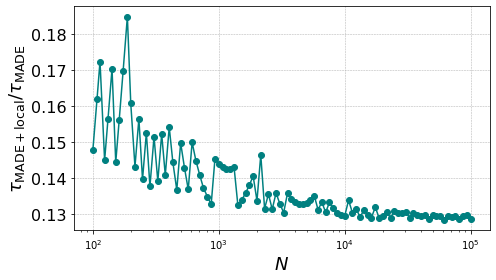

In [15]:
Nvalues = np.logspace(np.log10(100), np.log10(100000), 100).astype(int)
Nvalues = Nvalues + (Nvalues % 2)

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):
    N = Nvalues[i]
    beta = 1+1/N
    M = int(np.sqrt(3/beta**3*(beta-1))*N)
    M = M + (M % 2)
    m =M/N
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    nmax = int(N*m/2)

    #first passage time for Metropolis
    P = transition_matrix[:nmax, :nmax]
    fpt_metro = float(N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum())

    # first passage time for MADE
    cumulative = probMADE[nmax:].sum()
    fpt_made = 1/cumulative*N

    all_data.append([N, fpt_metro, fpt_made, M])
all_data = np.array(all_data)
# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

#for i, (d, color) in enumerate(zip(all_data, colors)):
#    dplot = d[d[:,1]>0]
plt.plot(all_data[:, 0], all_data[:, 1]/all_data[:,2], marker='o', color='teal')


#plt.yscale("log")
plt.xscale("log")

#plt.ylim(10**4, 10**8)
#plt.xlim(0.03)
plt.xlabel(r'$N$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
#plt.legend(title=r"$\beta$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

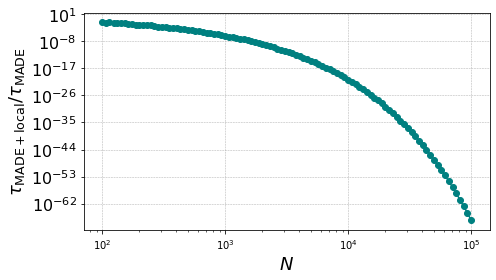

In [16]:
Nvalues = np.logspace(np.log10(100), np.log10(100000), 100).astype(int)
Nvalues = Nvalues + (Nvalues % 2)

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):
    N = Nvalues[i]
    beta = 1+1/np.sqrt(N)
    M = int(np.sqrt(1/beta**3*(beta-1))*N)
    M = M + (M % 2)
    m =M/N
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    nmax = int(N*m/2)

    #first passage time for Metropolis
    P = transition_matrix[:nmax, :nmax]
    fpt_metro = float(N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum())

    # first passage time for MADE
    cumulative = probMADE[nmax:].sum()
    fpt_made = 1/cumulative*N

    all_data.append([N, fpt_metro, fpt_made, M])
all_data = np.array(all_data)
# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

#for i, (d, color) in enumerate(zip(all_data, colors)):
#    dplot = d[d[:,1]>0]
plt.plot(all_data[:, 0], all_data[:, 1]/all_data[:,2], marker='o', color='teal')


plt.yscale("log")
plt.xscale("log")

#plt.ylim(10**4, 10**8)
#plt.xlim(0.03)
plt.xlabel(r'$N$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
#plt.legend(title=r"$\beta$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

## Figure 1 and 2

In [76]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

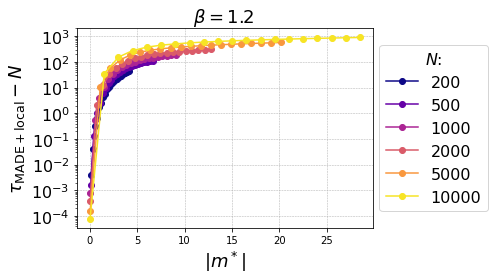

In [96]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = 0.3
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**0.5, (d[:, 1]-Nvalues[i])/ Nvalues[i]**0.5, marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} -N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
plt.title(r'$\beta=1.2$ ', fontsize=18)
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

### Figure 1

In [77]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = (thomas_solve(torch.eye(P.size(0))-P))[0]

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

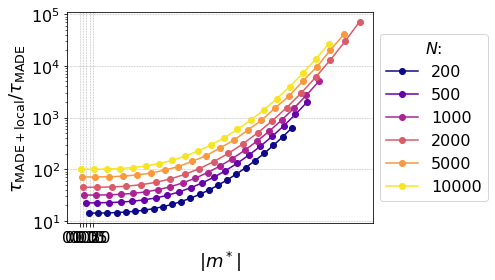

In [95]:
beta = 0 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()
        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**0.5, d[:, 1]/ Nvalues[i]**0.5, marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()
plt.savefig('fpt_ratio.png')
plt.savefig('fpt_ratio.pdf')


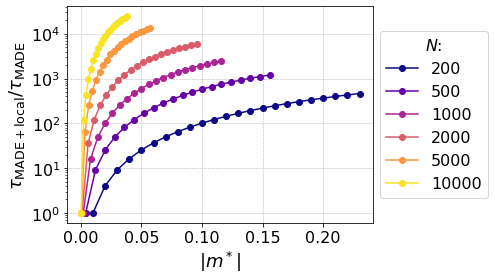

In [79]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = (thomas_solve(torch.eye(P.size(0))-P))[0]

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i], d[:, 1], marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()
plt.savefig('fpt_ratio.png')
plt.savefig('fpt_ratio.pdf')


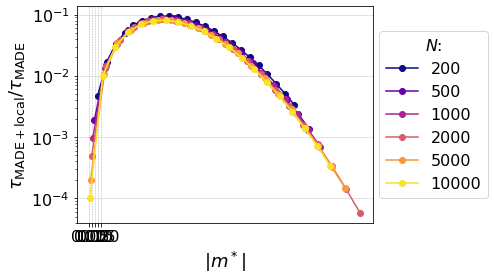

In [80]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = thomas_solve(torch.eye(P.size(0))-P)[0]

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**0.5, d[:, 1] / d[:, 2], marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()
plt.savefig('fpt_ratio.png')
plt.savefig('fpt_ratio.pdf')


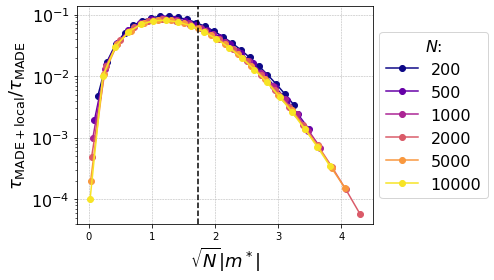

In [81]:
# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**0.5, d[:, 1] / d[:, 2], marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.2)
plt.xlabel(r'$\sqrt{N} |m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.axvline(x=np.sqrt(3), color='k', linestyle='--', label=r'$\sqrt{3}$')
plt.tight_layout()
plt.savefig('fpt_ratio.png')
plt.savefig('fpt_ratio.pdf')


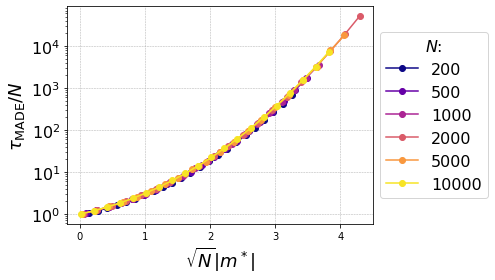

In [82]:
# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**0.5, d[:, 2]/Nvalues[i], marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$\sqrt{N} |m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE}}/N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

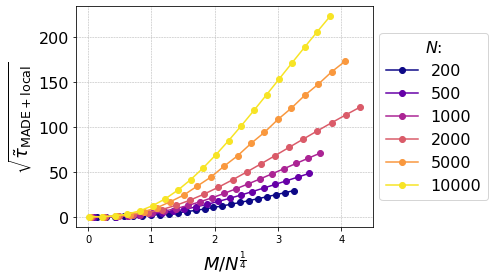

In [83]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = (0*N+thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)
all_data_withmade = list(all_data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0]/Nvalues[i]**0.5, (d[:, 1]-0*Nvalues[i])/Nvalues[i]**0.5, marker='o', label=f"{Nvalues[i]}", color=color)

#plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 200)
plt.xlabel(r'$M/N^\frac{1}{4}$', fontsize=18)
plt.ylabel(r'$\sqrt{\tilde{\tau}_{\mathrm{MADE+local}}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

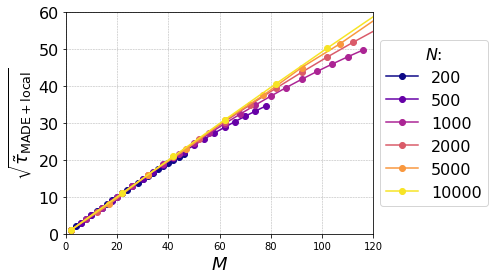

In [84]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = (thomas_solve(torch.eye(P.size(0))-P))[0]

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)
all_data_nomade = list(all_data)


# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0], (d[:, 1])**0.5, marker='o', label=f"{Nvalues[i]}", color=color)

#plt.xscale("log")
#plt.yscale("log")

#plt.ylim(10**(-3), 1.)
plt.xlim(0, 120)
plt.ylim(0, 60)

plt.xlabel(r'$M$', fontsize=18)
plt.ylabel(r'$\sqrt{\tilde{\tau}_{\mathrm{MADE+local}}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

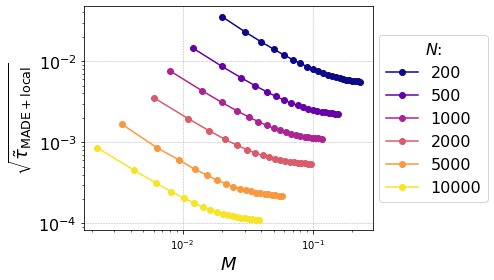

In [85]:
# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d1,d2, color) in enumerate(zip(all_data_nomade, all_data_withmade, colors)):
    plt.plot(d1[1:, 0]/Nvalues[i], d1[1:,1]/(d2[1:, 1]-Nvalues[i]*0)/Nvalues[i], marker='o', label=f"{Nvalues[i]}", color=color)

plt.xscale("log")
plt.yscale("log")

#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 120)
#plt.ylim(0, 60)

plt.xlabel(r'$M$', fontsize=18)
plt.ylabel(r'$\sqrt{\tilde{\tau}_{\mathrm{MADE+local}}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()

## Tempi che scalano come 1/N

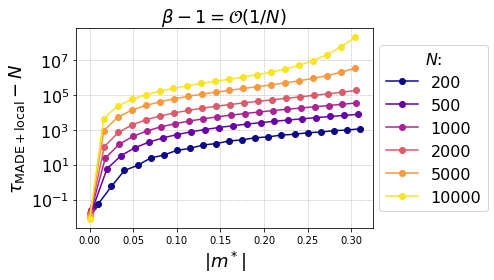

In [93]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):
    N = Nvalues[i]
    beta = 1+1/N
    m_max = 0.32
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**1, (d[:, 1]-Nvalues[i]), marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} -N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
plt.title(r'$\beta-1 = \mathcal{O}(1/N)$ ', fontsize=18)
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()


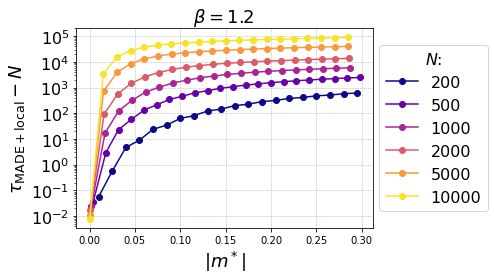

In [92]:
beta = 1.2 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = 0.3
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**1, (d[:, 1]-Nvalues[i]), marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.20)
plt.xlabel(r'$|m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} -N$', fontsize=18)  # Corrected to raw string with LaTeX formatting
plt.title(r'$\beta=1.2$ ', fontsize=18)
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()


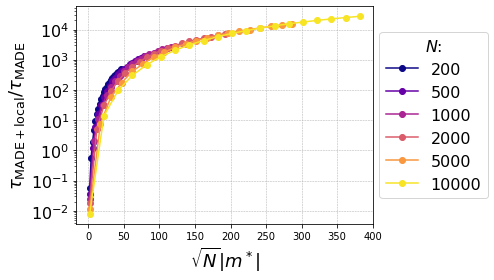

In [88]:
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

beta = 1.1

all_data = []
for i in range(len(Nvalues)):
    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum()

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:, 0] / Nvalues[i]**0, d[:, 1]-Nvalues[i], marker='o', label=f"{Nvalues[i]}", color=color)

plt.yscale("log")
#plt.ylim(10**(-3), 1.)
#plt.xlim(0, 0.2)
plt.xlabel(r'$\sqrt{N} |m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$N$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()
plt.savefig('fpt_ratio.png')
plt.savefig('fpt_ratio.pdf')

# Function of T

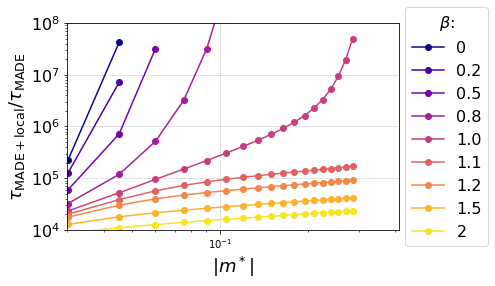

In [89]:
betavalues = [0,0.2,0.5,0.8,1.0, 1.1, 1.2, 1.5, 2]
N = 10000
m_max = 0.3

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(betavalues)):

    beta = betavalues[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = (thomas_solve(torch.eye(P.size(0))-P))[0]

        # first passage time for MADE
        cumulative = probMADE[nmax:].sum()
        fpt_made = 1/cumulative*N

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    dplot = d[d[:,1]>0]
    plt.plot(dplot[:, 0] / N, dplot[:, 1], marker='o', label=f"{betavalues[i]}", color=color)


plt.yscale("log")
plt.xscale("log")

plt.ylim(10**4, 10**8)
plt.xlim(0.03)
plt.xlabel(r'$|m^*|$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title=r"$\beta$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()
plt.savefig('fpt_ratio.png')
plt.savefig('fpt_ratio.pdf')

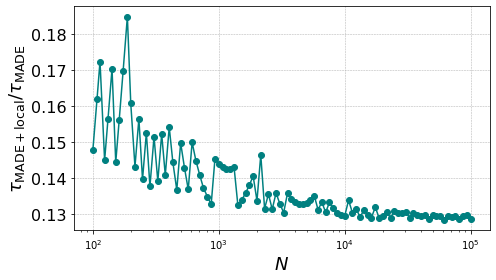

In [90]:
Nvalues = np.logspace(np.log10(100), np.log10(100000), 100).astype(int)
Nvalues = Nvalues + (Nvalues % 2)

#change depending on whether you want to use the central limit theorem or the large deviation function
MODE = "CLT"

all_data = []
for i in range(len(Nvalues)):
    N = Nvalues[i]
    beta = 1+1/N
    M = int(np.sqrt(3/beta**3*(beta-1))*N)
    M = M + (M % 2)
    m =M/N
    transition_matrix = get_transition_matrix_absm(N, beta)

    if MODE == "CLT":
        probMADE = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
        probMADE[0] = gaussian_m(0, N)
    else:
        probMADE = large_dev_m(np.arange(0, N-1, 2)/N, N)*2
        probMADE[0] = 1
        probMADE /= np.sum(probMADE)

    nmax = int(N*m/2)

    #first passage time for Metropolis
    P = transition_matrix[:nmax, :nmax]
    fpt_metro = float(N+(thomas_solve(torch.eye(P.size(0))-P)*probMADE[:nmax]).sum())

    # first passage time for MADE
    cumulative = probMADE[nmax:].sum()
    fpt_made = 1/cumulative*N

    all_data.append([N, fpt_metro, fpt_made, M])
all_data = np.array(all_data)
# Plot Fig. 1
plt.figure(figsize=(7, 4))
colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

#for i, (d, color) in enumerate(zip(all_data, colors)):
#    dplot = d[d[:,1]>0]
plt.plot(all_data[:, 0], all_data[:, 1]/all_data[:,2], marker='o', color='teal')


#plt.yscale("log")
plt.xscale("log")

#plt.ylim(10**4, 10**8)
#plt.xlim(0.03)
plt.xlabel(r'$N$', fontsize=18)
plt.ylabel(r'$\tau_{\mathrm{MADE+local}} / \tau_{\mathrm{MADE}}$', fontsize=18)  # Corrected to raw string with LaTeX formatting
#plt.xticks([0, 0.05, 0.10, 0.15, 0.20], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, ls="--", linewidth=0.5)
#plt.legend(title=r"$\beta$:", title_fontsize=16, fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()